In [10]:
import os # For directory and file manipulation
import shutil # For high-level file operations like copying and removal
import pandas as pd # For data manipulation and analysis
from tqdm import tqdm # For displaying a progress bar
import rasterio # For working with raster data (e.g., satellite imagery)
from rasterio.plot import show # For displaying raster data
import numpy as np # For numerical operations on arrays
import matplotlib.pyplot as plt # For plotting data and images
import seaborn as sns
import textwrap
from PIL import Image
import random

In [20]:
# Load the metadata
metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata.parquet')
updated_metadata_df = pd.read_parquet(r'C:\Users\isaac\FYPCode\updated_metadata_with_vectors.parquet')

# Base directories
source_base_dir = r'D:\datasets\2020-BigEarthNet-S2'
destination_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset'

In [12]:
# Extract unique labels from the metadata
unique_labels = metadata_df['labels'].explode().unique()

# Print the unique labels in a numbered table format
print("Unique Labels:")
for i, label in enumerate(unique_labels, start=1):
    print(f"{i}. {label}")

print()

Unique Labels:
1. Arable land
2. Broad-leaved forest
3. Mixed forest
4. Pastures
5. Inland waters
6. Coniferous forest
7. Complex cultivation patterns
8. Land principally occupied by agriculture, with significant areas of natural vegetation
9. Urban fabric
10. Industrial or commercial units
11. Inland wetlands
12. Transitional woodland, shrub
13. Natural grassland and sparsely vegetated areas
14. Moors, heathland and sclerophyllous vegetation
15. Marine waters
16. Coastal wetlands
17. Permanent crops
18. Beaches, dunes, sands
19. Agro-forestry areas



Processing category: Arable land
Processing category: Broad-leaved forest
Processing category: Mixed forest
Processing category: Pastures
Processing category: Inland waters
Processing category: Coniferous forest
Processing category: Complex cultivation patterns
Processing category: Land principally occupied by agriculture, with significant areas of natural vegetation
Processing category: Urban fabric
Processing category: Industrial or commercial units
Processing category: Inland wetlands
Processing category: Transitional woodland, shrub
Processing category: Natural grassland and sparsely vegetated areas
Processing category: Moors, heathland and sclerophyllous vegetation
Processing category: Marine waters
Processing category: Coastal wetlands
Processing category: Permanent crops
Processing category: Beaches, dunes, sands
Processing category: Agro-forestry areas


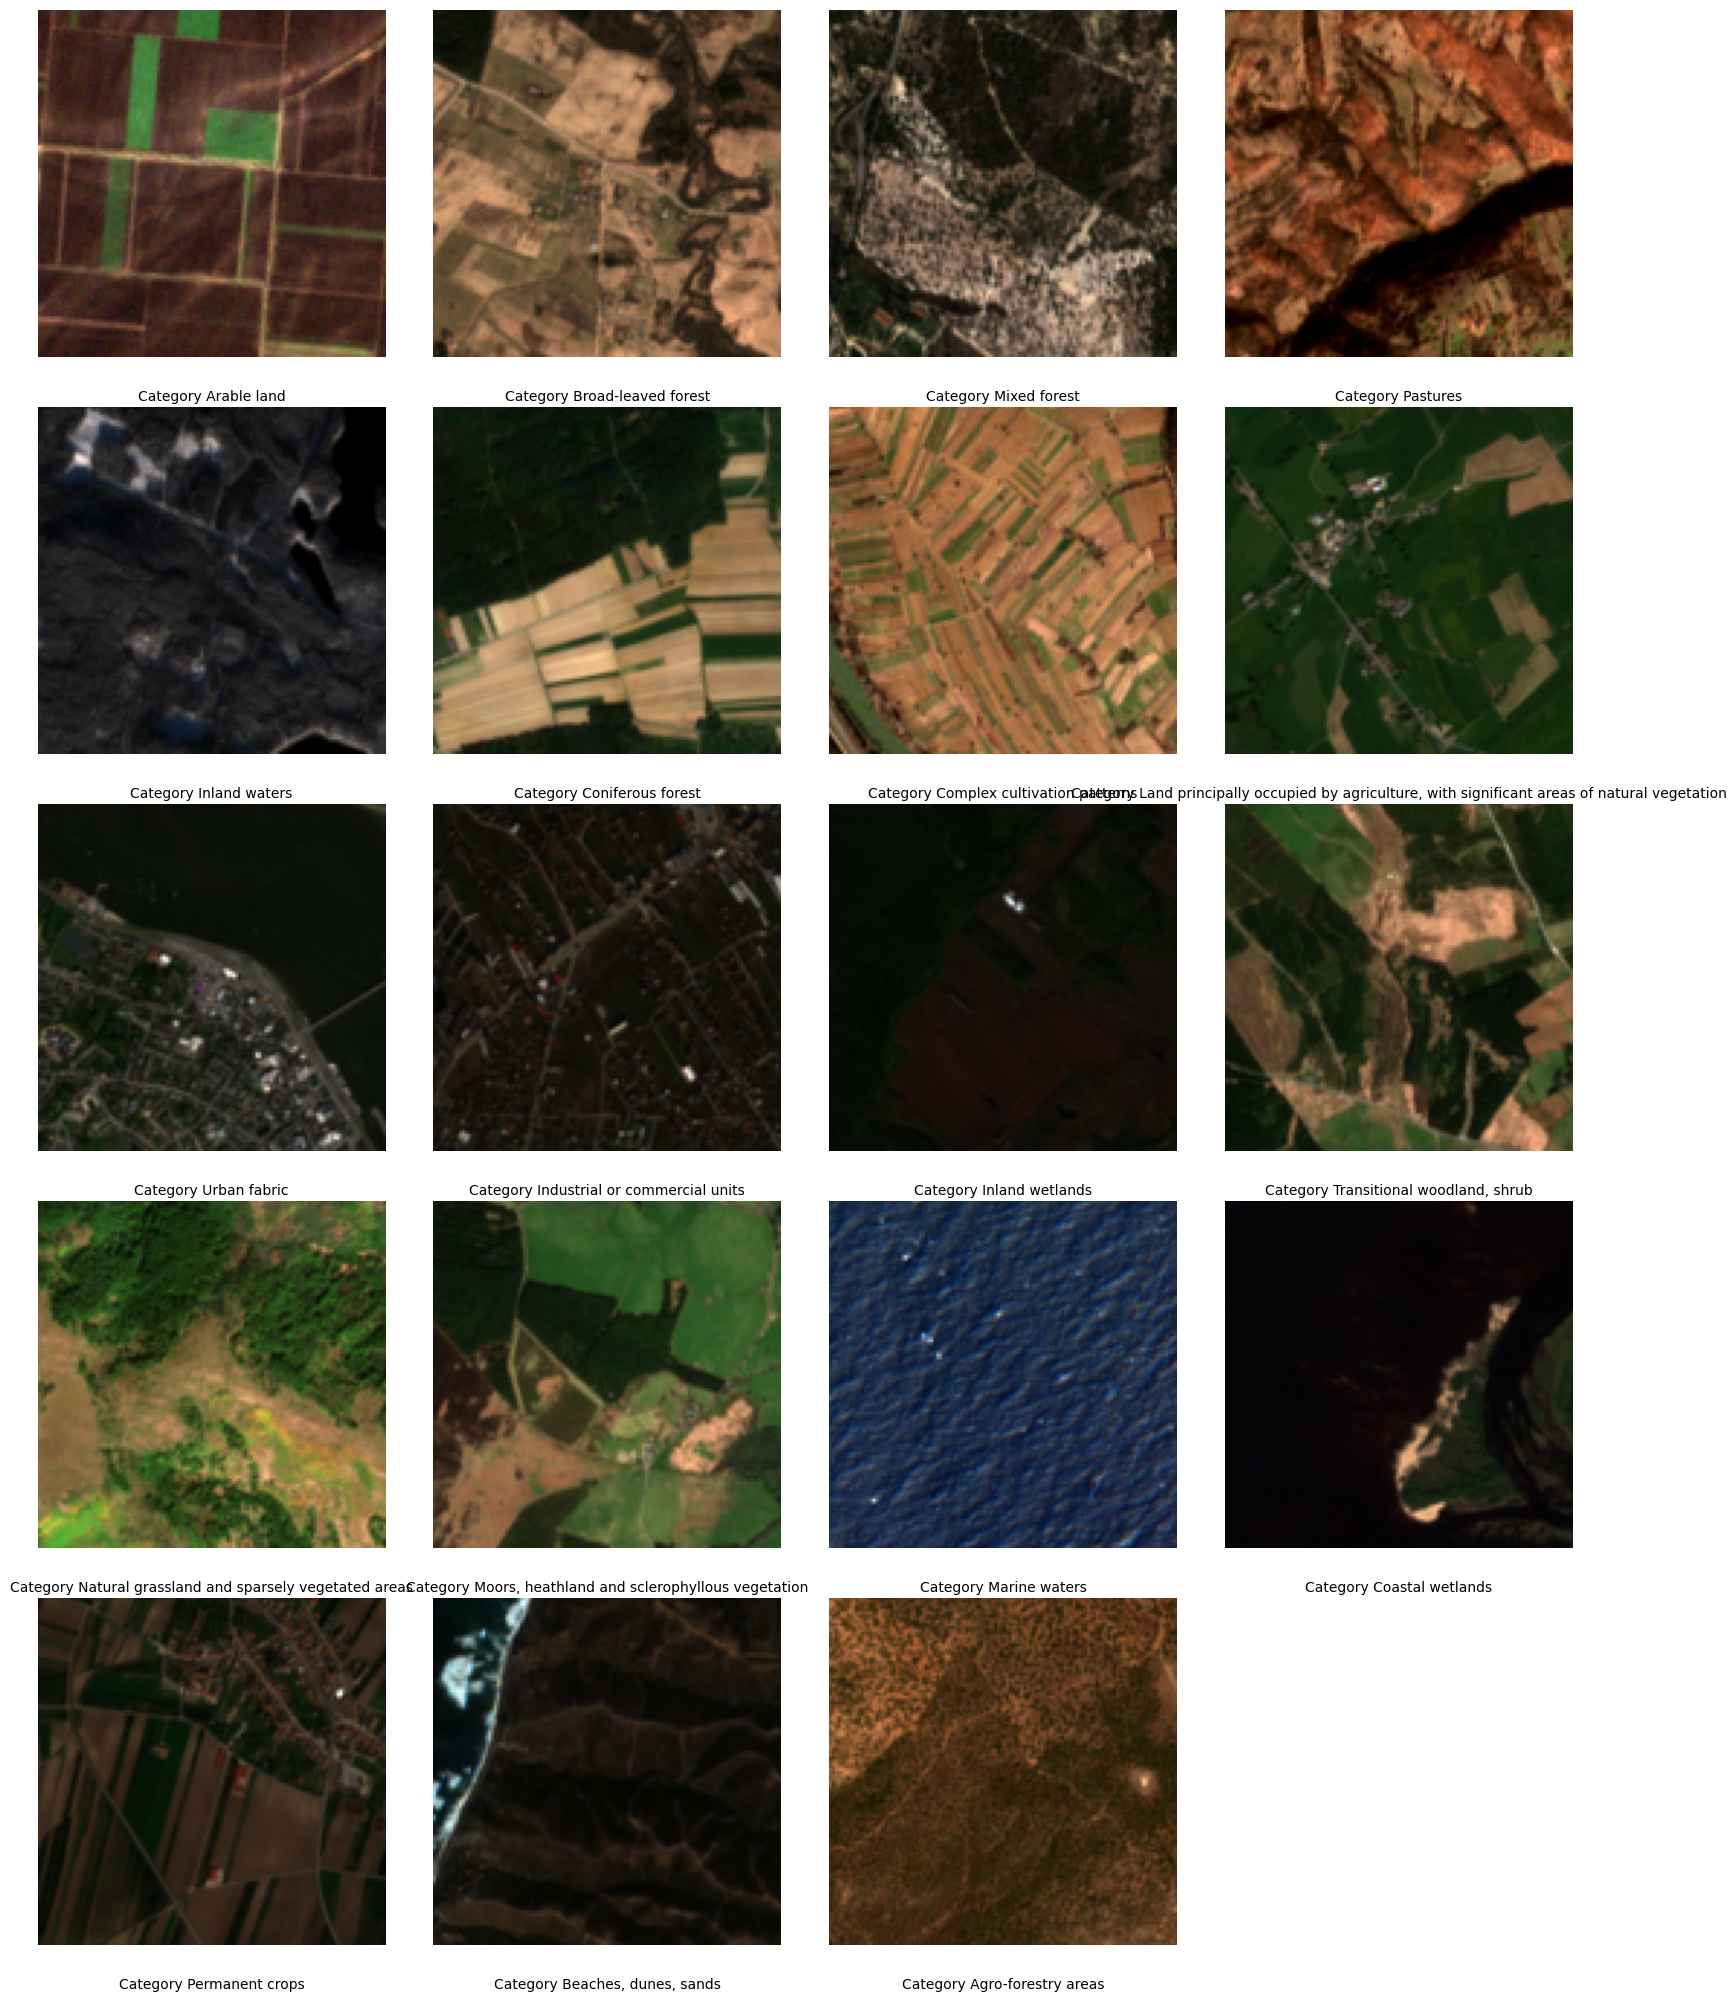

In [13]:
# List to store image paths
image_paths = []

# Iterate over each category
for category in unique_labels:
    print(f"Processing category: {category}")
    
    # Construct the directory path for the current category
    category_path = os.path.join(destination_base_dir, category)
    
    # Check if the directory exists
    if not os.path.exists(category_path):
        print(f"Directory not found: {category_path}")
        continue
    
    # Get the list of folders in the category
    folders = [f for f in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, f))]

    if len(folders) > 0:
        # Select a random folder in the category
        selected_folder = random.choice(folders)
        selected_folder_path = os.path.join(category_path, selected_folder)

        # Collect .tif files in the folder
        tif_files = [file for file in os.listdir(selected_folder_path) if file.lower().endswith('.tif')]
        
        if len(tif_files) >= 4:
            # Sort files to ensure consistent selection of bands
            tif_files.sort()
            # Construct full paths for the second, third, and fourth bands
            band_files = [os.path.join(selected_folder_path, tif_files[i]) for i in range(1, 4)]  # Bands 2, 3, 4
            
            image_paths.append(band_files)
        else:
            print(f"Not enough .tif files in folder: {selected_folder_path}")

# Calculate the number of rows and columns
num_images = len(image_paths)
num_cols = min(4, num_images)  # Set a max number of columns
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create a figure to display the images
plt.figure(figsize=(num_cols * 4, num_rows * 4))

# Iterate over each set of band files
for i, band_files in enumerate(image_paths, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    try:
        # Read the bands and stack them
        with rasterio.open(band_files[2]) as b2, rasterio.open(band_files[1]) as b3, rasterio.open(band_files[0]) as b4:
            band2 = b2.read(1)  # Read band 2
            band3 = b3.read(1)  # Read band 3
            band4 = b4.read(1)  # Read band 4
            
            # Stack bands into a 3-channel image (RGB)
            img = np.stack([band2, band3, band4], axis=-1)
            img = (img - img.min()) / (img.max() - img.min())  # Normalize image for visualization
            
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Category {unique_labels[i-1]}", fontsize=10, y=-0.15)
    except Exception as e:
        print(f"Error reading image bands {band_files}: {e}")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

In [ ]:
# Initialize a dictionary to hold the count of subfolders in each folder
folder_subfolder_counts = {}

# Iterate through each item in the base directory with a progress bar
for folder in tqdm(os.listdir(destination_base_dir), desc="Processing Folders", unit="folder"):
    folder_path = os.path.join(destination_base_dir, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # List all subdirectories within the current folder
        subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]
        
        # Count the number of subfolders
        subfolder_count = len(subfolders)
        
        # Store the count in the dictionary
        folder_subfolder_counts[folder] = subfolder_count

# Sort the dictionary by subfolder count in descending order
sorted_folder_counts = sorted(folder_subfolder_counts.items(), key=lambda x: x[1], reverse=True)

# Print header
print(f"{'Folder Name':<70} {'Subfolder Count':>15}")
print("-" * 85)

# Print the sorted number of subfolders in each folder in a formatted manner
for folder, count in sorted_folder_counts:
    print(f"{folder:<70} {count:>15}")

In [ ]:
# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Folder', y='Subfolder Count', data=df_folder_counts, palette='viridis')

# Add titles and labels
plt.title('Number of Subfolders per Folder', fontsize=16)
plt.xlabel('Folder Name', fontsize=14)
plt.ylabel('Number of Subfolders', fontsize=14)
plt.xticks(rotation=90)  # Rotate folder names if they are long

# Show the plot
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()

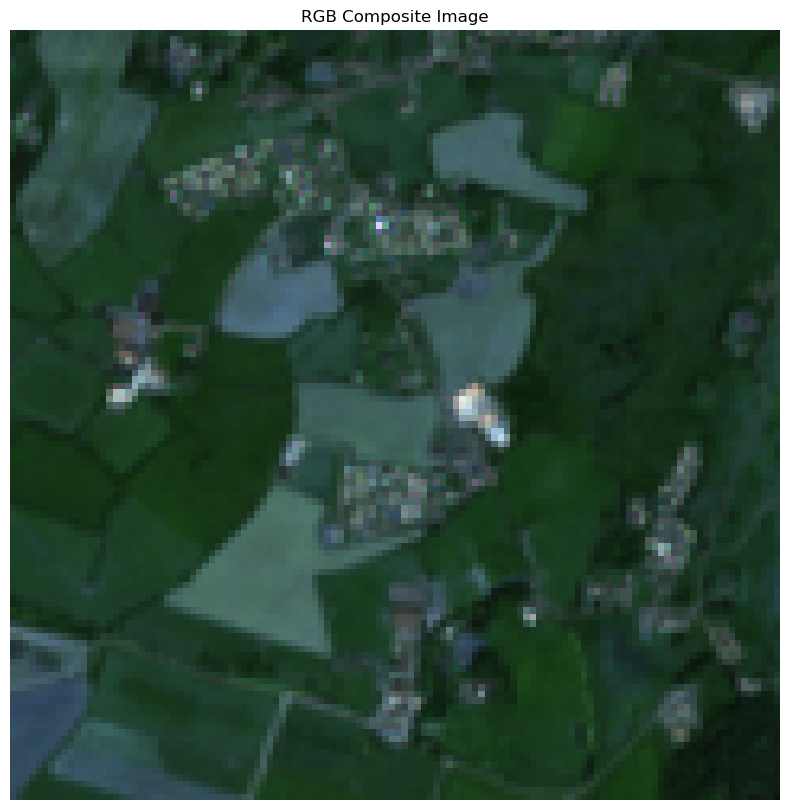

In [14]:
# File paths to the bands (modify these paths to your actual file locations)
band4_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Beaches, dunes, sands\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77_B02.tif'  # Red band
band3_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Beaches, dunes, sands\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77_B03.tif'
band2_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Beaches, dunes, sands\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77_B04.tif'

# Open the bands using Rasterio
with rasterio.open(band4_path) as band4, \
     rasterio.open(band3_path) as band3, \
     rasterio.open(band2_path) as band2:
    
    # Read each band into an array
    red = band4.read(1)
    green = band3.read(1)
    blue = band2.read(1)
    
    # Stack the bands to create an RGB image
    rgb = np.stack((red, green, blue), axis=-1)
    
    # Normalize the bands if necessary (optional)
    rgb = rgb / np.max(rgb)
    
    # Display the RGB image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.title("RGB Composite Image")
    plt.axis('off')
    plt.show()


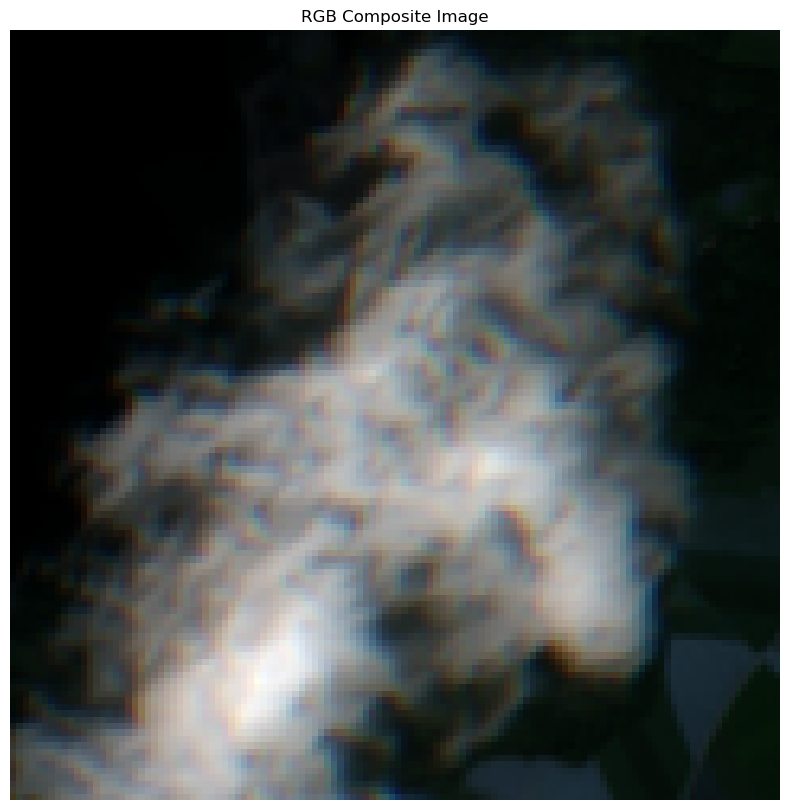

In [15]:
# File paths to the bands (modify these paths to your actual file locations)
band4_path = r'D:\datasets\2020-BigEarthNet-S2\Snow_Cloud_Shadow_patches\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_38_58\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_38_58_B02.tif'  # Red band
band3_path = r'D:\datasets\2020-BigEarthNet-S2\Snow_Cloud_Shadow_patches\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_38_58\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_38_58_B03.tif'
band2_path = r'D:\datasets\2020-BigEarthNet-S2\Snow_Cloud_Shadow_patches\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_38_58\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_38_58_B04.tif'

# Open the bands using Rasterio
with rasterio.open(band4_path) as band4, \
     rasterio.open(band3_path) as band3, \
     rasterio.open(band2_path) as band2:
    
    # Read each band into an array
    red = band4.read(1)
    green = band3.read(1)
    blue = band2.read(1)
    
    # Stack the bands to create an RGB image
    rgb = np.stack((red, green, blue), axis=-1)
    
    # Normalize the bands if necessary (optional)
    rgb = rgb / np.max(rgb)
    
    # Display the RGB image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.title("RGB Composite Image")
    plt.axis('off')
    plt.show()


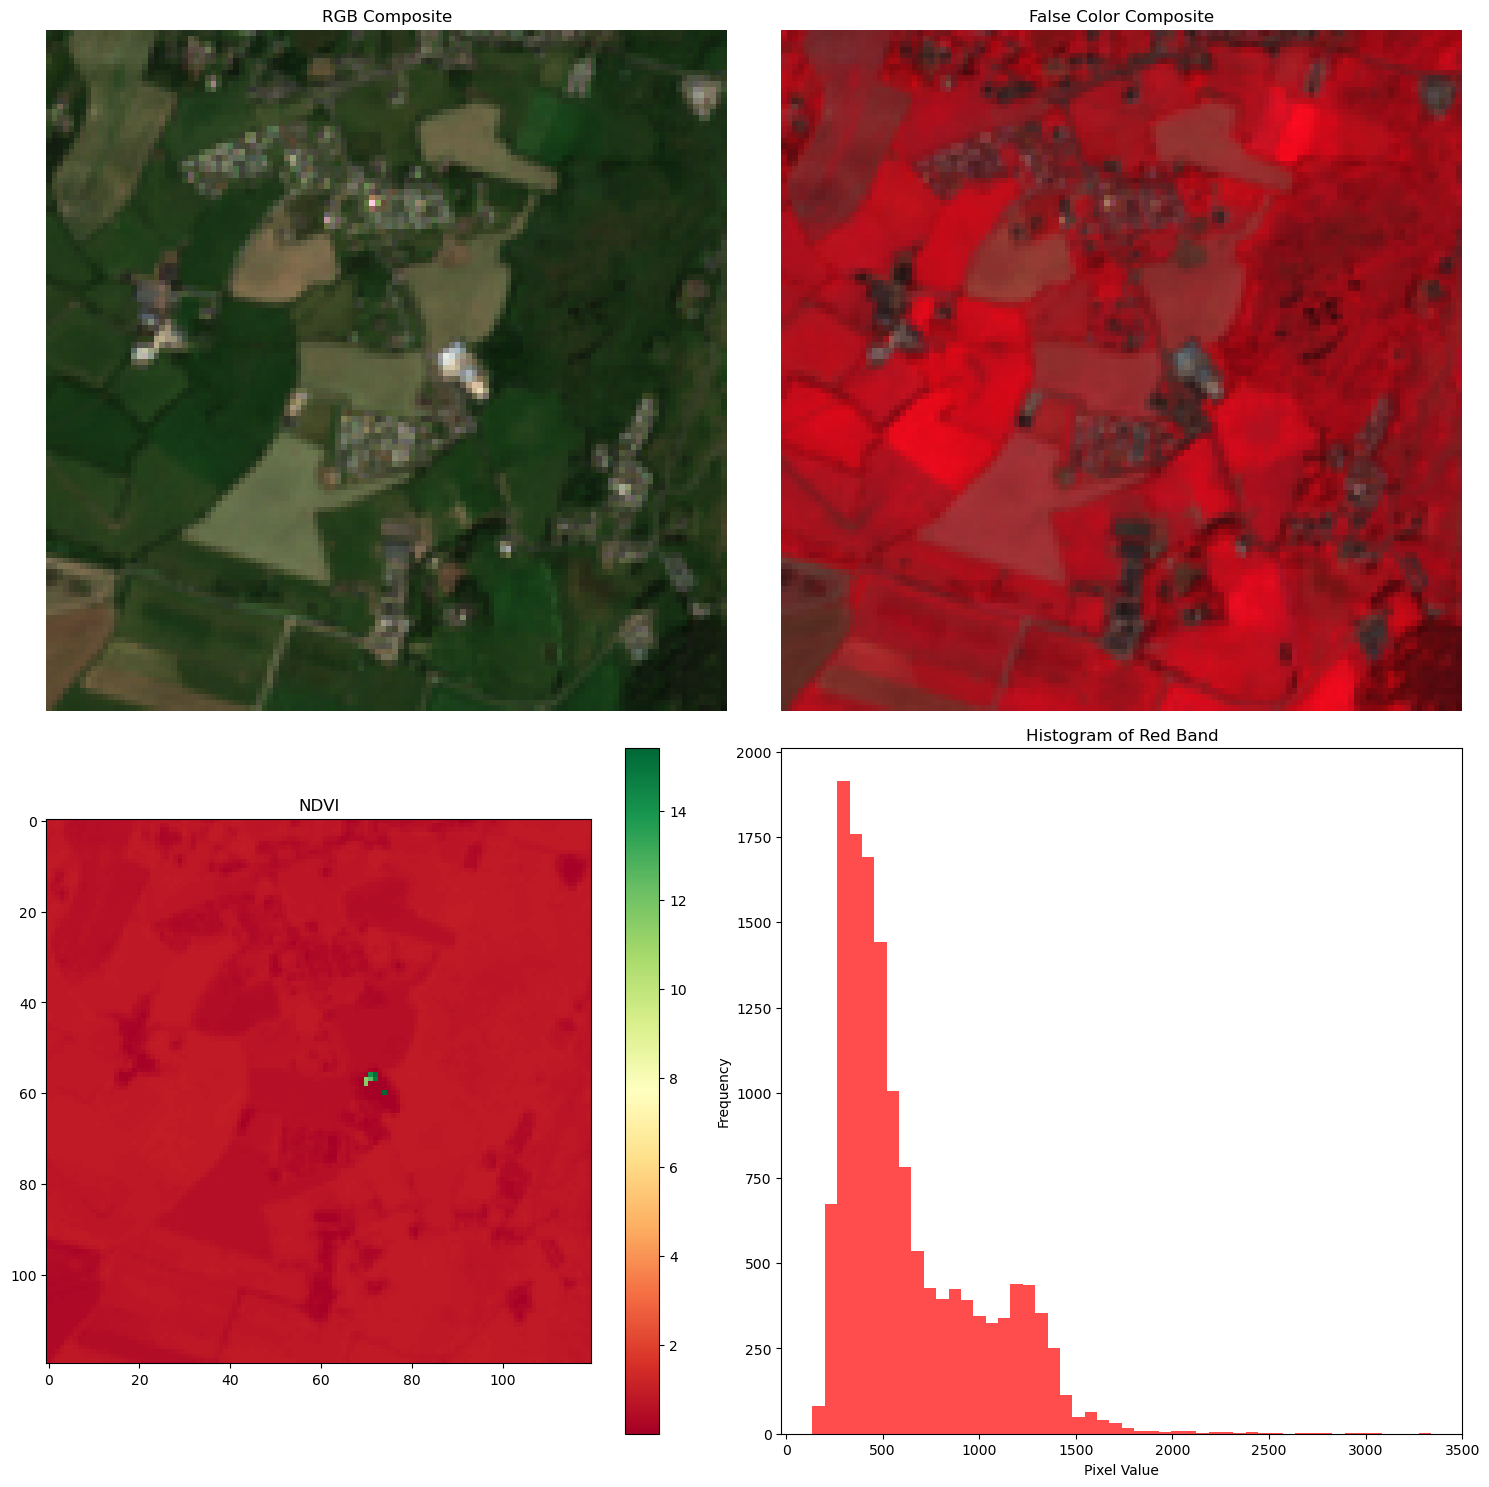

In [5]:
# File paths to the bands
band4_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Beaches, dunes, sands\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77_B04.tif'  # Red band
band3_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Beaches, dunes, sands\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77_B03.tif'
band2_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Beaches, dunes, sands\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77_B02.tif'
nir_path = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset\Beaches, dunes, sands\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77\S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_65_77_B08.tif'  # NIR band

# Open the bands using Rasterio
with rasterio.open(band4_path) as band4, \
     rasterio.open(band3_path) as band3, \
     rasterio.open(band2_path) as band2, \
     rasterio.open(nir_path) as nir_band:
    
    red = band4.read(1)
    green = band3.read(1)
    blue = band2.read(1)
    nir = nir_band.read(1)
    
    # RGB Composite
    rgb = np.stack((red, green, blue), axis=-1)
    rgb = rgb / np.max(rgb)
    
    # False Color Composite (NIR, Red, Green)
    false_color = np.stack((nir, red, green), axis=-1)
    false_color = false_color / np.max(false_color)
    
    # NDVI
    ndvi = (nir - red) / (nir + red)
    
    # Display results
    plt.figure(figsize=(15, 15))

    plt.subplot(2, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Composite")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(false_color)
    plt.title("False Color Composite")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.title("NDVI")
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.hist(red.ravel(), bins=50, color='red', alpha=0.7)
    plt.title("Histogram of Red Band")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


In [18]:
# Define the patch_id you're interested in
target_patch_id = 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_56'  # Replace with your specific patch_id

# Filter the DataFrame to get the row with the matching patch_id
matching_row = metadata_df.loc[metadata_df['patch_id'] == target_patch_id]

# If a match is found, extract the labels
if not matching_row.empty:
    labels = matching_row['labels'].values[0]
    split = matching_row['split'].values[0]
    print(f'Labels for patch_id {target_patch_id}: {labels}')
    print(f'Split: {split}')
else:
    print(f'No matching patch_id found for {target_patch_id}')


Labels for patch_id S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_56: ['Arable land' 'Broad-leaved forest' 'Coniferous forest' 'Inland waters'
 'Mixed forest']
Split: test


In [2]:
# Read the data
metadata_df = pd.read_parquet(r'C:\Users\isaac\Desktop\SampleBigEarth\metadata.parquet')

# Convert numpy.ndarray to list if necessary
metadata_df['labels'] = metadata_df['labels'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Filter rows where 'labels' contain only "Arable land"
arable_land_only = metadata_df[metadata_df['labels'].apply(lambda x: x == ['Arable land'])]

# Count the number of such rows
num_arable_land_only = arable_land_only.shape[0]
print(f"Number of records with the label 'Arable land' uniquely: {num_arable_land_only}")

# Filter rows where 'labels' contain "Arable land" among other labels
arable_land_present = metadata_df[metadata_df['labels'].apply(lambda x: 'Arable land' in x and len(x) > 1)]

# Count the number of such rows
num_arable_land_present = arable_land_present.shape[0]
print(f"Number of records with 'Arable land' among other labels: {num_arable_land_present}")

# Define the target labels
target_labels = ['Arable land', 'Mixed forest', 'Coniferous forest']

# Filter rows where 'labels' contain exactly the target labels
exact_three_labels = metadata_df[metadata_df['labels'].apply(lambda x: sorted(x) == sorted(target_labels))]

# Count the number of such rows
num_exact_three_labels = exact_three_labels.shape[0]
print(f"Number of records with exactly the labels 'Arable land', 'Mixed forest', and 'Coniferous forest': {num_exact_three_labels}")

Number of records with the label 'Arable land' uniquely: 14893
Number of records with 'Arable land' among other labels: 173132
Number of records with exactly the labels 'Arable land', 'Mixed forest', and 'Coniferous forest': 3815


In [29]:
num_rows = updated_metadata_df.shape[0]
print(f"The DataFrame contains {num_rows} rows.")

print()

# Convert numpy.ndarray to list if necessary
updated_metadata_df['labels'] = updated_metadata_df['labels'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Count the number of labels per record
updated_metadata_df['label_count'] = updated_metadata_df['labels'].apply(len)

# Get the counts for each label count
single_label_count = updated_metadata_df[updated_metadata_df['label_count'] == 1].shape[0]
two_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 2].shape[0]
three_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 3].shape[0]
four_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 4].shape[0]
five_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 5].shape[0]
six_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 6].shape[0]
seven_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 7].shape[0]
eight_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 8].shape[0]
nine_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 9].shape[0]
ten_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 10].shape[0]
more_than_ten_labels_count = updated_metadata_df[updated_metadata_df['label_count'] > 10].shape[0]

# Print the results
print(f"Number of records with a single label: {single_label_count}")
print(f"Number of records with 2 labels: {two_labels_count}")
print(f"Number of records with 3 labels: {three_labels_count}")
print(f"Number of records with 4 labels: {four_labels_count}")
print(f"Number of records with 5 labels: {five_labels_count}")
print(f"Number of records with 6 labels: {six_labels_count}")
print(f"Number of records with 7 labels: {seven_labels_count}")
print(f"Number of records with 8 labels: {eight_labels_count}")
print(f"Number of records with 9 labels: {nine_labels_count}")
print(f"Number of records with 10 labels: {ten_labels_count}")
print(f"Number of records with more than 10 labels: {more_than_ten_labels_count}")

print()

# Calculate the total number of records
total_records = (single_label_count + two_labels_count + three_labels_count +
                 four_labels_count + five_labels_count + six_labels_count +
                 seven_labels_count + eight_labels_count + nine_labels_count +
                 ten_labels_count + more_than_ten_labels_count)

# Print the total number of records
print(f"Total number of records: {total_records}")

The DataFrame contains 480038 rows.

Number of records with a single label: 86375
Number of records with 2 labels: 94649
Number of records with 3 labels: 135885
Number of records with 4 labels: 102036
Number of records with 5 labels: 45329
Number of records with 6 labels: 12963
Number of records with 7 labels: 2478
Number of records with 8 labels: 302
Number of records with 9 labels: 15
Number of records with 10 labels: 1
Number of records with more than 10 labels: 5

Total number of records: 480038


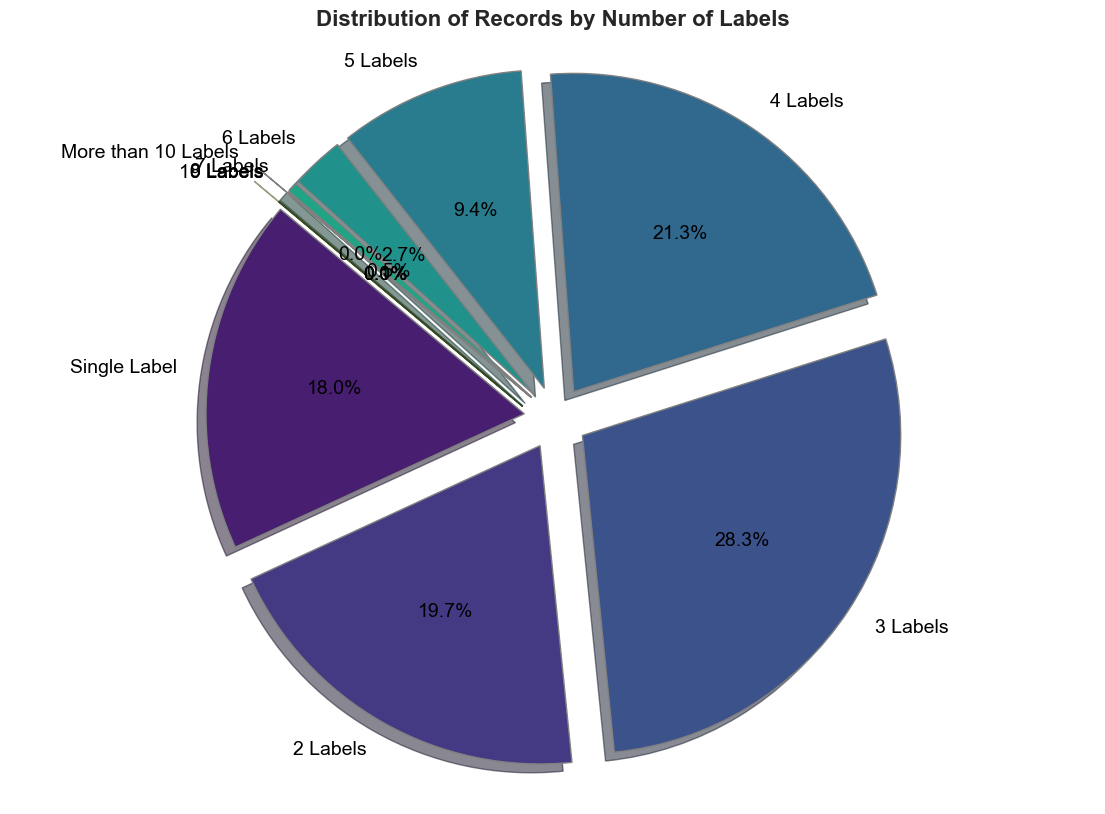

In [31]:
# Set Seaborn style
sns.set_style("whitegrid")

# Data for the pie chart
sizes = [single_label_count, two_labels_count, three_labels_count, four_labels_count, 
         five_labels_count, six_labels_count, seven_labels_count, eight_labels_count, 
         nine_labels_count, ten_labels_count, more_than_ten_labels_count]
labels = ['Single Label', '2 Labels', '3 Labels', '4 Labels', '5 Labels', '6 Labels', 
          '7 Labels', '8 Labels', '9 Labels', '10 Labels', 'More than 10 Labels']

# Use 'viridis' color palette from Seaborn
colors = sns.color_palette('viridis', len(sizes))  # Adjust the number of colors as needed

# Explode the segment for 'More than 10 Labels' for emphasis
explode = [0.1] * 10 + [0.2]  # Explode the last segment ("More than 10 Labels") more

# Create the pie chart
plt.figure(figsize=(14, 10))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        explode=explode, shadow=True, textprops={'fontsize': 14, 'color': 'black'}, wedgeprops={'edgecolor': 'grey'})

# Title of the pie chart
plt.title('Distribution of Records by Number of Labels', fontsize=16, weight='bold')

# Display the pie chart
plt.axis('equal')
plt.savefig('images/distribution_of_records_by_labels_piechart.png')  # Ensure the path is correct
plt.show()

In [23]:
# Get the count of records with exactly 1 label that is "Arable land"
one = updated_metadata_df[
    (updated_metadata_df['label_count'] == 1) &
    (updated_metadata_df['labels'].apply(lambda x: x == ['Arable land']))
].shape[0]

print(f"Number of records with exactly 1 label and the label is 'Arable land': {one}")

# Get the count of records with exactly 2 labels that are "Arable land" and "Mixed forest"
two = updated_metadata_df[
    (updated_metadata_df['label_count'] == 2) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest'}))
].shape[0]

print(f"Number of records with exactly 2 labels 'Arable land' and 'Mixed forest': {two}")

# Get the count of records with exactly 3 labels that are "Arable land", "Mixed forest" and "Coniferous forest"
three = updated_metadata_df[
    (updated_metadata_df['label_count'] == 3) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest', 'Coniferous forest'}))
].shape[0]

print(f"Number of records with exactly 3 labels 'Arable land', 'Mixed forest' and 'Coniferous forest' : {three}")

# Get the count of records with exactly 3 labels that are "Arable land", "Mixed forest", "Coniferous forest" and "Transitional woodland, shrub"
four = updated_metadata_df[
    (updated_metadata_df['label_count'] == 4) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub'}))
].shape[0]

print(f"Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest' and 'Transitional woodland, shrub': {four}")

five = updated_metadata_df[
    (updated_metadata_df['label_count'] == 5) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub', 'Broad-leaved forest'}))
].shape[0]

print(f"Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub' and 'Broad-leaved forest': {five}")


Number of records with exactly 1 label and the label is 'Arable land': 14893
Number of records with exactly 2 labels 'Arable land' and 'Mixed forest': 1507
Number of records with exactly 3 labels 'Arable land', 'Mixed forest' and 'Coniferous forest' : 3815
Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest' and 'Transitional woodland, shrub': 3216
Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub' and 'Broad-leaved forest': 493
